### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics

from sklearn.preprocessing import scale

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

import cv2

### Reading data

In [2]:
# Read data
mnist_data = pd.read_csv("mnist.csv").values

# Split labels and image data
digit_labels = mnist_data[:, 0]
image_data   = mnist_data[:, 1:]

# Determine amont of rows and columns
nr_of_rows_in_data, nr_of_cols_in_data = image_data.shape

# Enumerate digits 0..9
digits = np.array(range(10)).astype("int")

### Plot an image from the data

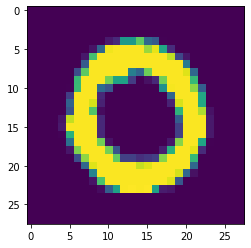

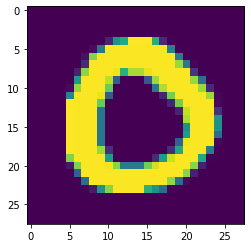

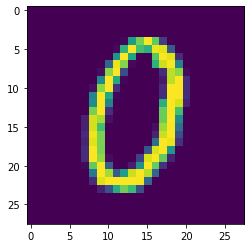

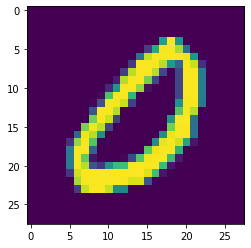

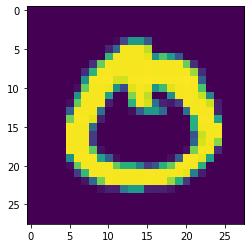

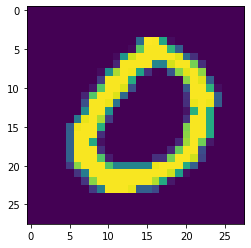

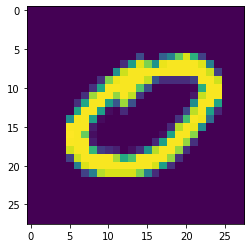

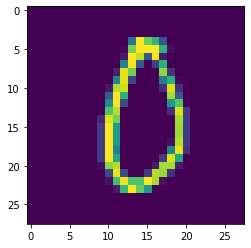

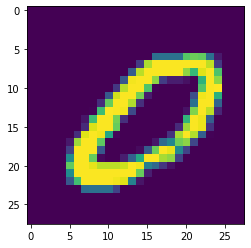

In [3]:
# Plot the image "image_number" from the data
image_number = 0

image_size = 28
for image_number in range(100):
    if digit_labels[image_number] == 0:
        plt.imshow(image_data[image_number].reshape(image_size, image_size))
        plt.show()

### Ink feature

#### Counting border changes

In [4]:
def borderchanges(array, image_size):

    return borderchanges_leftright(array, image_size) + borderchanges_topdown(array, image_size)

def borderchanges_leftright(array, image_size):
    nr_of_columns = len(array)

    count_changes_to_from_0 = 0

    for i in range(0, nr_of_columns - 1):

        # Don't count change from most-right column to most-left column of the next row
        if i % image_size == image_size - 1:
            continue

        # If value goes from 0 to nonzero, add 1 to count
        if array[i] == 0:
            if array[i + 1] != 0:
                count_changes_to_from_0 += 1

            continue
        
        # If value goes from nonzero to 0, add 1 to count (value is nonzero because of previous if-statement)
        if array[i + 1] == 0:
            count_changes_to_from_0 += 1

    return count_changes_to_from_0

def borderchanges_topdown(array, image_size):
    nr_of_columns = len(array)

    count_changes_to_from_0 = 0

    for k in range(0, nr_of_columns - 1):
        
        # Translate to top-down counterpart
        k_mod = k % image_size
        k_div = k / image_size
        i = int(k_mod * image_size + k_div)
        
        # Don't count change from lowest row to highest row in next column
        if i % image_size == image_size - 1:
            continue

        # If value goes from 0 to nonzero, add 1 to count
        if array[i] == 0:
            if array[i + 1] != 0:
                count_changes_to_from_0 += 1

            continue
        
        # If value goes from nonzero to 0, add 1 to count (value is nonzero because of previous if-statement)
        if array[i + 1] == 0:
            count_changes_to_from_0 += 1

    return count_changes_to_from_0

#### Raw features

In [20]:
# Determine amount of ink for each image
ink    = np.array([sum(image) for image in image_data])
area   = np.array([np.count_nonzero(image) for image in image_data])
border = np.array([borderchanges(image, image_size) for image in image_data])

raw_features_data_named = [("ink", ink), ("area", area), ("border", border)]

Mean and standard deviation for all features

 Digit         Mean  Standard Deviation
   0.0 34632.407551         8461.892043
   1.0 15188.466268         4409.461697
   2.0 29871.099354         7653.006199
   3.0 28320.188003         7574.104536
   4.0 24232.722495         6374.633457
   5.0 25835.920422         7526.602989
   6.0 27734.917331         7530.503187
   7.0 22931.244263         6168.340878
   8.0 30184.148413         7777.396357
   9.0 24553.750000         6465.231330


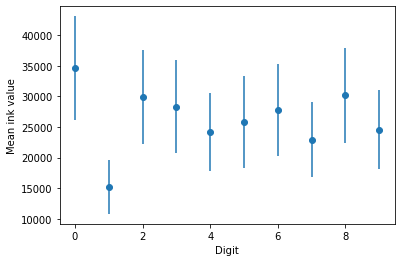

 Digit       Mean  Standard Deviation
   0.0 191.742982           33.698980
   1.0  85.732067           20.008382
   2.0 168.967920           33.055455
   3.0 163.519880           33.634468
   4.0 141.499509           27.916642
   5.0 152.755468           33.766286
   6.0 158.210056           32.651863
   7.0 131.421041           27.029581
   8.0 173.973419           32.830988
   9.0 143.251433           28.536829


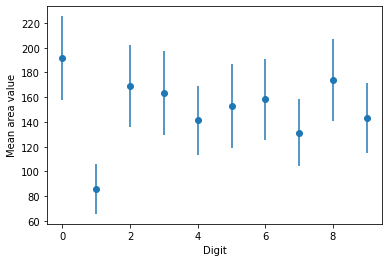

 Digit       Mean  Standard Deviation
   0.0 126.122459           12.832962
   1.0  80.801879            3.782859
   2.0  97.374192           14.800825
   3.0  95.294875           10.465391
   4.0 112.637525           11.042259
   5.0  90.060079           12.839357
   6.0 105.529611           15.923316
   7.0  90.683935           10.413245
   8.0 111.380753           12.616086
   9.0 103.138013           11.357146


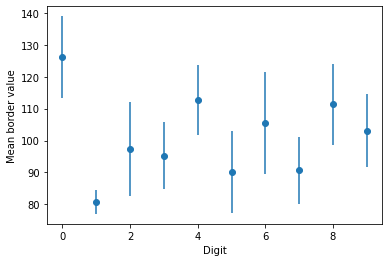

In [24]:
# Plot mean and standard deviation for each feature
for feature_name, feature_data in raw_features_data_named:

    # Compute mean and standard deviation for the feature for each digit 
    feature_mean    = [np.mean(feature_data[digit_labels == i]) for i in digits]
    feature_std_dev = [np.std(feature_data[digit_labels == i])  for i in digits]

    # Put the mean and standard deviation for each digit in a dataframe
    feature_all_values = np.column_stack((digits, feature_mean, feature_std_dev))
    feature_dataframe  = pd.DataFrame(data = feature_all_values, columns = ["Digit", "Mean", "Standard Deviation"])

    # Save and print dataframe
    feature_dataframe.to_csv("Raw Features Data/feature_data_" + feature_name + ".csv")
    print(feature_dataframe.to_string(index = False))

    # Plot the mean and standard deviation for each digit and save figure to file
    plt.errorbar(digits, feature_mean, feature_std_dev, linestyle = "None", marker = "o")
    plt.xlabel("Digit")
    plt.ylabel("Mean " + feature_name + " value")
    plt.savefig("Raw Features Data/feature_plot_" + feature_name + ".jpg")
    plt.show()

Low values between 12000 and 18000 (or even lower) likely point to digit "1"

High values above 38000 are most probably the digit "0"

For values inbetween, the amounts of ink are very close

"0"    34632
"1"    15188
"2"    29871
"3"    28230
"4"    24232
"5"    25835
"6"    27734
"7"    22931
"8"    30184
"9"    24553

0 -> 8 -> 2 -> 3 -> 6 -> 5 -> 9 -> 4 -> 7 -> 1

#### Scale features data and combine features

In [7]:
# Reshape to a feature which can be used for Logistic Regression
ink_reshaped    = scale(ink).reshape(-1, 1)
area_reshaped   = scale(area).reshape(-1, 1)
border_reshaped = scale(border).reshape(-1, 1)

# Combine features in all possible ways
ink_and_area            = np.column_stack((ink_reshaped, area_reshaped))
ink_and_border          = np.column_stack((ink_reshaped, border_reshaped))
area_and_border         = np.column_stack((area_reshaped, border_reshaped))
ink_and_area_and_border = np.column_stack((ink_reshaped, area_reshaped, border_reshaped))

features_data_named = [("ink", ink_reshaped), ("area", area_reshaped), ("border", border_reshaped), 
                       ("ink and area", ink_and_area), ("ink and border", ink_and_border), ("area and border", area_and_border), 
                       ("ink and area and border", ink_and_area_and_border)]

#### Logistic Regression

In [8]:
def LogisticRegression_FullData_ConfusionMatrix_And_Accuracy(data, labels, model_parameters):

    # Fit Logistic Regression model to full data
    logistic_regression_model = LogisticRegression(penalty = model_parameters["penalty"], solver = model_parameters["solver"])
    logistic_regression_model.fit(data, labels)

    # Get predictions on full data
    labels_predictions = logistic_regression_model.predict(data)

    # Print the confusion matrix, accuracy etc.
    confusion_matrix = metrics.confusion_matrix(labels, labels_predictions)
    accuracy         = metrics.accuracy_score(labels, labels_predictions)

    return (accuracy, confusion_matrix)

#### Perform Logistic Regression on all features (and comvbinations of features)

In [9]:
# Params
logistic_regression_parameters_list = [{"penalty": "none", "solver": "lbfgs"}, {"penalty": "l1", "solver": "liblinear"}, {"penalty": "l2", "solver": "liblinear"}]

# Confusion matrices and accuracies
confusion_matrices_and_accuracies = [] 

for logistic_regression_parameters in logistic_regression_parameters_list:

    for feature_name, feature_data in features_data_named:

       penalty = logistic_regression_parameters["penalty"]

       accuracy, confusion_matrix = LogisticRegression_FullData_ConfusionMatrix_And_Accuracy(feature_data, digit_labels, logistic_regression_parameters)

       confusion_matrices_and_accuracies.append((feature_name, penalty, accuracy, confusion_matrix))    

Predicting majority class

In [10]:
# Prediction of majority class
majority_class_row_count = np.bincount(digit_labels).max()
majority_class_prediction_accuracy = majority_class_row_count / nr_of_rows_in_data

Accuracies

In [23]:
# Accuracies logistic regression models and for predicting the majority class
with open("Logistic Regression Accuracies/accuracies.txt", "w") as accuracies_file:

    print("Accuracy of Predicting Majority Class: " + str(majority_class_prediction_accuracy) + "\n")
    accuracies_file.write("Accuracy of Predicting Majority Class: " + str(majority_class_prediction_accuracy) + "\n")

    for feature_name, penalty, accuracy, confusion_matrix in confusion_matrices_and_accuracies:

        print("Accuracy of Logistic Regression (penalty " + penalty + ") with feature(s) " + feature_name + ": " + str(accuracy) + "\n")
        accuracies_file.write("Accuracy of Logistic Regression (penalty " + penalty + ") with feature(s) " + feature_name + ": " + str(accuracy) + "\n")

Confusion matrices

In [27]:
for feature_name, penalty, accuracy, confusion_matrix in confusion_matrices_and_accuracies:
    
    # Print confusion matrix
    print("Confusion Matrix of Logistic Regression (penalty " + penalty + ") with feature(s) " + feature_name + ": ")
    print(confusion_matrix)
    
    # Save confusion matrix
    with open("Digit Comparisons/Confusion Matrices/confusion_matrix_" + feature_name + "_penalty_" + penalty + ".txt", "w") as confusion_matrix_file:
        confusion_matrix_file.write(str(confusion_matrix.tolist()))

Confusion Matrix of Logistic Regression (penalty none) with feature(s) ink: 
[[2420   83  322  805    0    0    0  384    0  118]
 [  10 3823    5  101    0    0    0  722    0   23]
 [1495  280  327 1038    0    0    0  874    0  163]
 [1246  408  335 1037    0    0    0 1141    0  184]
 [ 440  829  196  886    0    0    0 1496    0  225]
 [ 727  671  198  846    0    0    0 1190    0  163]
 [1057  450  296  982    0    0    0 1145    0  207]
 [ 325 1190  149  818    0    0    0 1700    0  219]
 [1430  192  343 1047    0    0    0  879    0  172]
 [ 484  763  197  869    0    0    0 1651    0  224]]
Confusion Matrix of Logistic Regression (penalty none) with feature(s) area: 
[[2511    7  130  850    0    0    0  230  190  214]
 [   3 4044    1   24    0    0    0  575    0   37]
 [1459   95  142 1092    0    0    0  769  195  425]
 [1298  180  131 1122    0    0    0  916  179  525]
 [ 332  387   75  952    0    0    0 1705   87  534]
 [ 727  297   92  915    0    0    0 1149  139  4

Compare accuracy of distinguishing between all digits

In [18]:
for feature_name, penalty, accuracy, confusion_matrix in confusion_matrices_and_accuracies:

    # Write accuracies for distinguishing between digits to file
    with open("Digit Comparisons/comparisons_" + feature_name + "_penalty_" + penalty + ".txt", "w") as comparisons_file:

        # Determine digits which are dropped by the model
        predictions_per_digit = confusion_matrix.sum(axis = 0)

        dropped_digits = np.argwhere(predictions_per_digit == 0).flatten()

        # Determine output string for the dropped digits and write to file
        if len(dropped_digits) == 0:
            dropped_digits_string = "No digits dropped by the model!"
        else:
            dropped_digits_string = "Digits that are dropped by the model: " + ", ".join(dropped_digits.astype("str"))

        comparisons_file.write(dropped_digits_string + "\n\n")

        # Determine and write all accuracies of distinguishing between digits
        comparisons_file.write("First Digit, Second Digit: Accuracy\n")

        for first_digit in digits:
            for second_digit in digits:

                if second_digit <= first_digit:
                    continue

                # Determine confusion matrix for the digits
                digits_confusion_matrix_array = [confusion_matrix[first_digit, first_digit], 
                                                 confusion_matrix[first_digit, second_digit], 
                                                 confusion_matrix[second_digit, first_digit], 
                                                 confusion_matrix[second_digit, second_digit]]

                digits_all_predictions = sum(digits_confusion_matrix_array)
                digits_right_predictions = digits_confusion_matrix_array[0] + digits_confusion_matrix_array[3]
                digits_accuracy = digits_right_predictions / digits_all_predictions if digits_all_predictions != 0 else None

                comparisons_file.write(str(first_digit) + ", " + str(second_digit) + ": " + str(digits_accuracy) + "\n")